# Skin Care Recommendation System
### 1. Importing Libraries

In [2]:
%pip install markovify

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

import nltk
from sklearn.feature_extraction.text import CountVectorizer #Tranforms each word on the basis of frequency
from sklearn.feature_extraction.text import TfidfVectorizer #Term frequency inverse frequency 
#It evaluates how relevant a document in a collection of documents

from sklearn.feature_extraction.text import TfidfTransformer
#CountVectorizer + tfidTransformer = tfidVectorizer
from nltk.probability import FreqDist # It evaluates the number of times each output of an experiment has occured
from nltk.corpus import stopwords     # Commonly occuring words (they provide very less information)
from nltk.stem import PorterStemmer  # It provides root word (choco ,chocolato  ->chocolate (root word)
#from sklearn import metrics
from sklearn.model_selection import train_test_split 
from matplotlib import cm #Built-in color maps
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score 
from sklearn.metrics import f1_score   # 1= best, worst =0
from nltk.tokenize import RegexpTokenizer  #Splits a string into sub string using regular expression
from nltk.stem  import WordNetLemmatizer  
''' Lemmatization is a process of converting a word to its base and meaningful form while stemming is a process of removing 
last charecters of words often leading to incorrct meanings and spelling errors'''
# WordNet is a collection of  nouns , verbs ........ into a groups and each group describes a uniqure concept
from sklearn.metrics.pairwise import cosine_similarity
from bokeh.io import show, curdoc, output_notebook, push_notebook
from bokeh.plotting import figure 
from bokeh.models import ColumnDataSource,HoverTool, Select, Paragraph,Text
# Bokeh is used for creating interactive visualtzations(from simple plot to complex dashboards without streaming dataset, ..........we can create js povered visul without writing js 
from ipywidgets import interact
import markovify             #It alows the prediction of the future state on the basis of the present state
from os import path
from PIL import Image         #Python image library (used for image processing)
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator # It is tecnique for data visuliztion in text in which the size of each word tells the frequency or importance
from sklearn.pipeline import Pipeline  
from sklearn.naive_bayes import MultinomialNB      # The number of times each word has occured
from sklearn.linear_model import SGDClassifier # Sochastic gradient descent algo
from sklearn.linear_model import LogisticRegression
import warnings;warnings.simplefilter('ignore')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
from sklearn.metrics import ndcg_score

def precision_at_k(y_true, y_pred, k=10):
    """
    Calculate Precision@K for recommendation system
    """
    if len(y_pred) < k:
        k = len(y_pred)
    if k == 0:
        return 0.0
    
    # Convert to binary relevance (1 if relevant, 0 if not)
    relevant_items = set(y_true)
    recommended_items = set(y_pred[:k])
    
    if len(recommended_items) == 0:
        return 0.0
    
    hits = len(relevant_items.intersection(recommended_items))
    return hits / k

def recall_at_k(y_true, y_pred, k=10):
    """
    Calculate Recall@K for recommendation system
    """
    if len(y_pred) < k:
        k = len(y_pred)
        
    relevant_items = set(y_true)
    recommended_items = set(y_pred[:k])
    
    if len(relevant_items) == 0:
        return 0.0
    
    hits = len(relevant_items.intersection(recommended_items))
    return hits / len(relevant_items)

def ndcg_at_k(y_true, y_pred_scores, k=10):
    """
    Calculate NDCG@K for recommendation system
    """
    if len(y_pred_scores) < k:
        k = len(y_pred_scores)
    
    # Create ideal ranking (perfect relevance) - this would typically come from ground truth
    # For our case, we'll create a binary relevance based on y_true
    ideal_relevance = []
    for i in range(len(y_pred_scores)):
        if i < len(y_true):  # If this position is in the true relevant items
            ideal_relevance.append(1)  # Relevant
        else:
            ideal_relevance.append(0)  # Not relevant
    
    # Create predicted relevance based on recommendations
    pred_relevance = []
    for item_score in y_pred_scores[:k]:
        pred_relevance.append(item_score)  # Use the similarity score as relevance
    
    # Ensure we have the right shape for ndcg_score
    ideal_relevance = [ideal_relevance[:k]]
    pred_relevance = [pred_relevance]
    
    try:
        return ndcg_score(ideal_relevance, pred_relevance, k=k)
    except ValueError:
        # Handle case where arrays are not compatible
        return 0.0

In [5]:
from sklearn.metrics import classification_report 
df = pd.read_csv("https://raw.githubusercontent.com/kasmya/AI-Cosmetic-Reccomendation-System/refs/heads/main/skindataall.csv", index_col=[0])
df.head()


Username Skin_Tone    Skin_Type Eye_Color Hair_Color  Rating_Stars  \
0      allyp3    Medium  Combination     Brown   Brunette             5   
1      PatTea    Medium  Combination     Brown        Red             1   
2    Sabi1991   No data      No data   No data    No data             5   
3  happyface2      Fair          Dry      Blue     Blonde             5   
4    kimkix34      Fair       Normal     Green     Blonde             5   

                                              Review  \
0  This is hands down the best cleanser I’ve ever...   
1  Unfortunately this doesn’t work for everyone. ...   
2  My favorite cleanser!! i love the packaging on...   
3  I love all things Youth To The People! This cl...   
4  I had a trial size of this and was obsessed. M...   

                          Product                Brand  Price  ...  Oily  \
0  Superfood Antioxidant Cleanser  YOUTH TO THE PEOPLE     36  ...     0   
1  Superfood Antioxidant Cleanser  YOUTH TO THE PEOPLE     36  ...     0   
2  Superfood Antioxidant Cleanser  YOUTH TO THE PEOPLE     36  ...     0   
3  Superfood Antioxidant Cleanser  YOUTH TO THE PEOPLE     36  ...     0   
4  Superfood Antioxidant Cleanser  YOUTH TO THE PEOPLE     36  ...     0   

  Sensitive  Category                                        Product_Url  \
0         0  Cleanser  https://www.sephora.com/product/kale-spinach-g...   
1         0  Cleanser  https://www.sephora.com/product/kale-spinach-g...   
2         0  Cleanser  https://www.sephora.com/product/kale-spinach-g...   
3         0  Cleanser  https://www.sephora.com/product/kale-spinach-g...   
4         0  Cleanser  https://www.sephora.com/product/kale-spinach-g...   

   User_id  Product_id                                Ingredients_Cleaned  \
0     3420         157  ['sodium', 'cocoyl', 'glutamate', 'cocamidopro...   
1     2483         157  ['sodium', 'cocoyl', 'glutamate', 'cocamidopro...   
2     2715         157  ['sodium', 'cocoyl', 'glutamate', 'cocamidopro...   
3     4497         157  ['sodium', 'cocoyl', 'glutamate', 'cocamidopro...   
4     5017         157  ['sodium', 'cocoyl', 'glutamate', 'cocamidopro...   

                                      Review_Cleaned Good_Stuff  \
0  ['hand', 'best', 'cleanser', 'ever', 'used', '...          1   
1  ['unfortunately', 'work', 'everyone', 'used', ...          0   
2  ['favorite', 'cleanser', 'love', 'packaging', ...          1   
3  ['love', 'thing', 'youth', 'people', 'cleanser...          1   
4  ['trial', 'size', 'wa', 'obsessed', 'skin', 'f...          1   

                                           Ing_Tfidf  
0  sodium, cocoyl, glutamate, cocamidopropyl, bet...  
1  sodium, cocoyl, glutamate, cocamidopropyl, bet...  
2  sodium, cocoyl, glutamate, cocamidopropyl, bet...  
3  sodium, cocoyl, glutamate, cocamidopropyl, bet...  
4  sodium, cocoyl, glutamate, cocamidopropyl, bet...  

[5 rows x 25 columns]

### 2. EDA and Data Visualization


<Axes: xlabel='Skin_Tone'>

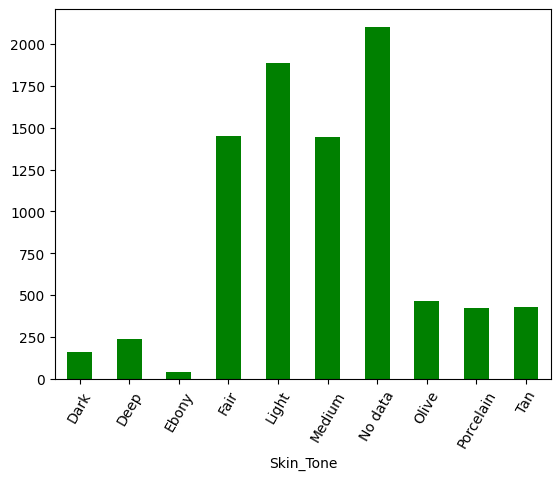

In [6]:
skintone_status= df.groupby('Skin_Tone')['Username'].count()
skintone_status.plot.bar(color='green',rot=60)

In [7]:
skintype_stats=df.groupby('Skin_Type')['Username'].count()

<Axes: xlabel='Skin_Type'>

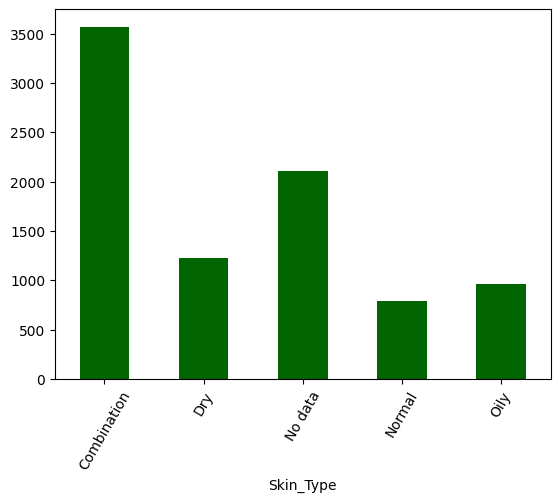

In [8]:
skintype_stats.plot.bar(color='darkgreen',rot=60)

<Axes: xlabel='Eye_Color'>

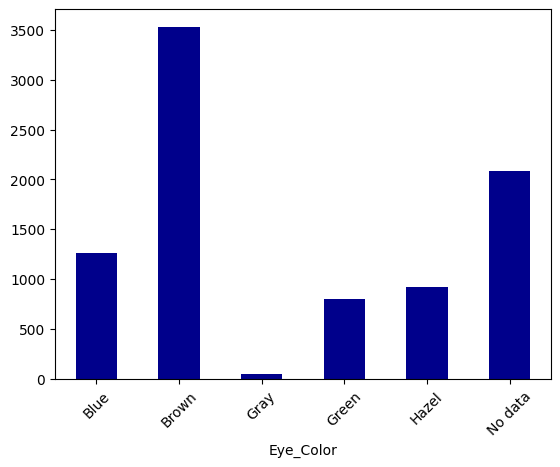

In [9]:
eyecolor_stats = df.groupby('Eye_Color')['Username'].count()
eyecolor_stats.plot.bar(color='darkblue',rot=45)

<Axes: xlabel='Hair_Color'>

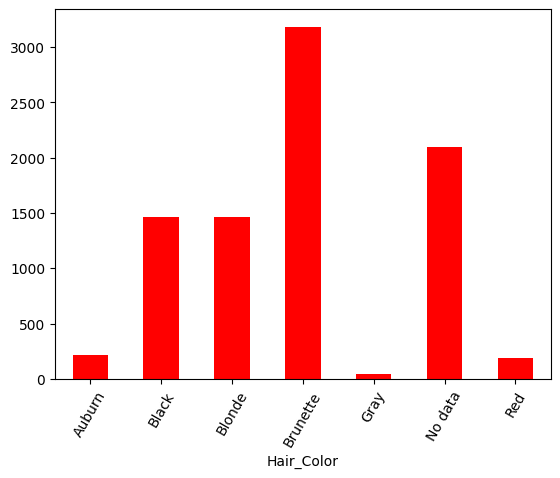

In [10]:
haircolor_stats =df.groupby('Hair_Color')['Username'].count()
haircolor_stats.plot.bar(color='red',rot=60)

<Axes: xlabel='Rating_Stars'>

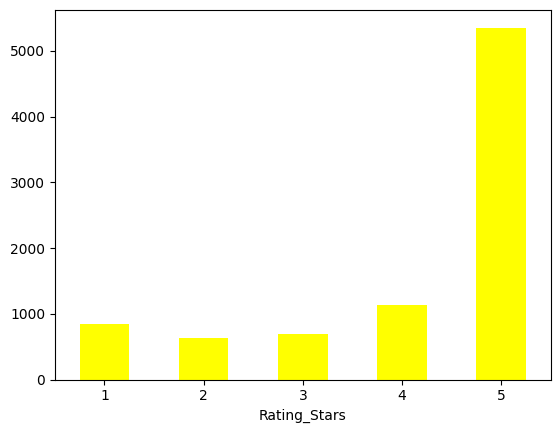

In [11]:
rating_stats = df.groupby('Rating_Stars')['Username'].count()
rating_stats.plot.bar(color='yellow',rot=0)

### 3. Using Language Generators


In [12]:
# Removing all the punctautions
# Pass row one by one in this function
import re
def no_punc(string):
    # replace by empty string
    # w is for capital and small words and s is for spaces, ^ is not , all will be saved in string variable
    no_punc_string=re.sub('[^\w\s]','',string)
    return no_punc_string

In [13]:
df['Review'] = df.apply(lambda row: no_punc(row['Review']),axis=1)

In [14]:
df['Review'].head()

0    This is hands down the best cleanser Ive ever ...
1    Unfortunately this doesnt work for everyone I ...
2    My favorite cleanser i love the packaging on t...
3    I love all things Youth To The People This cle...
4    I had a trial size of this and was obsessed My...
Name: Review, dtype: object

In [15]:
#See datascience + markovify
text_model = markovify.NewlineText(df.Review,state_size=2)
for i in range(1):
    print(text_model.make_sentence())

A keeper of a bigger one The bottle it took my make up and make everything baby smooth after I already bought 2nd bottle


In [16]:
# 1 to 4 will be considered as negative rating
negative_df = df[df.Rating_Stars<=4]
negative_df.head()

Username  Skin_Tone    Skin_Type Eye_Color Hair_Color  Rating_Stars  \
1         PatTea     Medium  Combination     Brown        Red             1   
5        TABrown    No data      No data   No data    No data             2   
6       britcorm  Porcelain         Oily      Blue   Brunette             1   
18  keyz2thejeep       Dark  Combination     Brown     Blonde             4   
20       Vani241      Olive         Oily     Brown      Black             3   

                                               Review  \
1   Unfortunately this doesnt work for everyone I ...   
5   There is nothing great about this cleanser I g...   
6   Been trying this cleanser for about 3 weeks no...   
18  Best cleaner Ive ever used Gets my face nice a...   
20  There are Pros and Cons to this cleanser This ...   

                           Product                Brand  Price  ...  Oily  \
1   Superfood Antioxidant Cleanser  YOUTH TO THE PEOPLE     36  ...     0   
5   Superfood Antioxidant Cleanser  YOUTH TO THE PEOPLE     36  ...     0   
6   Superfood Antioxidant Cleanser  YOUTH TO THE PEOPLE     36  ...     0   
18  Superfood Antioxidant Cleanser  YOUTH TO THE PEOPLE     36  ...     0   
20  Superfood Antioxidant Cleanser  YOUTH TO THE PEOPLE     36  ...     0   

   Sensitive  Category                                        Product_Url  \
1          0  Cleanser  https://www.sephora.com/product/kale-spinach-g...   
5          0  Cleanser  https://www.sephora.com/product/kale-spinach-g...   
6          0  Cleanser  https://www.sephora.com/product/kale-spinach-g...   
18         0  Cleanser  https://www.sephora.com/product/kale-spinach-g...   
20         0  Cleanser  https://www.sephora.com/product/kale-spinach-g...   

    User_id  Product_id                                Ingredients_Cleaned  \
1      2483         157  ['sodium', 'cocoyl', 'glutamate', 'cocamidopro...   
5      3008         157  ['sodium', 'cocoyl', 'glutamate', 'cocamidopro...   
6      3776         157  ['sodium', 'cocoyl', 'glutamate', 'cocamidopro...   
18     4996         157  ['sodium', 'cocoyl', 'glutamate', 'cocamidopro...   
20     3210         157  ['sodium', 'cocoyl', 'glutamate', 'cocamidopro...   

                                       Review_Cleaned Good_Stuff  \
1   ['unfortunately', 'work', 'everyone', 'used', ...          0   
5   ['nothing', 'great', 'cleanser', 'got', 'small...          0   
6   ['trying', 'cleanser', 'week', 'glad', 'bought...          0   
18  ['best', 'cleaner', 'ever', 'used', 'get', 'fa...          0   
20  ['pro', 'con', 'cleanser', 'cleaner', 'believe...          0   

                                            Ing_Tfidf  
1   sodium, cocoyl, glutamate, cocamidopropyl, bet...  
5   sodium, cocoyl, glutamate, cocamidopropyl, bet...  
6   sodium, cocoyl, glutamate, cocamidopropyl, bet...  
18  sodium, cocoyl, glutamate, cocamidopropyl, bet...  
20  sodium, cocoyl, glutamate, cocamidopropyl, bet...  

[5 rows x 25 columns]

In [17]:
positive_df = df[df.Rating_Stars>4]
positive_df.head()

Username Skin_Tone    Skin_Type Eye_Color Hair_Color  Rating_Stars  \
0      allyp3    Medium  Combination     Brown   Brunette             5   
2    Sabi1991   No data      No data   No data    No data             5   
3  happyface2      Fair          Dry      Blue     Blonde             5   
4    kimkix34      Fair       Normal     Green     Blonde             5   
7     jenn887       Tan          Dry     Brown      Black             5   

                                              Review  \
0  This is hands down the best cleanser Ive ever ...   
2  My favorite cleanser i love the packaging on t...   
3  I love all things Youth To The People This cle...   
4  I had a trial size of this and was obsessed My...   
7  loveeeeeee this cleanser Leaves my skin smooth...   

                          Product                Brand  Price  ...  Oily  \
0  Superfood Antioxidant Cleanser  YOUTH TO THE PEOPLE     36  ...     0   
2  Superfood Antioxidant Cleanser  YOUTH TO THE PEOPLE     36  ...     0   
3  Superfood Antioxidant Cleanser  YOUTH TO THE PEOPLE     36  ...     0   
4  Superfood Antioxidant Cleanser  YOUTH TO THE PEOPLE     36  ...     0   
7  Superfood Antioxidant Cleanser  YOUTH TO THE PEOPLE     36  ...     0   

  Sensitive  Category                                        Product_Url  \
0         0  Cleanser  https://www.sephora.com/product/kale-spinach-g...   
2         0  Cleanser  https://www.sephora.com/product/kale-spinach-g...   
3         0  Cleanser  https://www.sephora.com/product/kale-spinach-g...   
4         0  Cleanser  https://www.sephora.com/product/kale-spinach-g...   
7         0  Cleanser  https://www.sephora.com/product/kale-spinach-g...   

   User_id  Product_id                                Ingredients_Cleaned  \
0     3420         157  ['sodium', 'cocoyl', 'glutamate', 'cocamidopro...   
2     2715         157  ['sodium', 'cocoyl', 'glutamate', 'cocamidopro...   
3     4497         157  ['sodium', 'cocoyl', 'glutamate', 'cocamidopro...   
4     5017         157  ['sodium', 'cocoyl', 'glutamate', 'cocamidopro...   
7     4742         157  ['sodium', 'cocoyl', 'glutamate', 'cocamidopro...   

                                      Review_Cleaned Good_Stuff  \
0  ['hand', 'best', 'cleanser', 'ever', 'used', '...          1   
2  ['favorite', 'cleanser', 'love', 'packaging', ...          1   
3  ['love', 'thing', 'youth', 'people', 'cleanser...          1   
4  ['trial', 'size', 'wa', 'obsessed', 'skin', 'f...          1   
7  ['loveeeeeee', 'cleanser', 'leaf', 'skin', 'sm...          1   

                                           Ing_Tfidf  
0  sodium, cocoyl, glutamate, cocamidopropyl, bet...  
2  sodium, cocoyl, glutamate, cocamidopropyl, bet...  
3  sodium, cocoyl, glutamate, cocamidopropyl, bet...  
4  sodium, cocoyl, glutamate, cocamidopropyl, bet...  
7  sodium, cocoyl, glutamate, cocamidopropyl, bet...  

[5 rows x 25 columns]

In [18]:
positive_df['Username'].count()

np.int64(5356)

In [19]:
#Forming a string from the negative df | Space means that there will be space between 2 rows
negative = " ".join(review for review in negative_df.Review)
negative

'Unfortunately this doesnt work for everyone I used it once and woke up the nxt day with 5 pimples used it again and again and again but woke up with more and more Finally i couldnt take it anymore I stopped using it went back to my cerave hydrating cleanser and Bam My skin was clearing up every day after that I suggest getting the small bottle to try it out first Remember everyones skin is very different\nread more There is nothing great about this cleanser I got the small size bottle to try out and would certainly never spend my money to buy this It did remove my makeup so this got 2 stars instead of one but it did nothing for my skin In fact I had some uneven texture after using this for a while There are much better cleansers out there Been trying this cleanser for about 3 weeks now and its not for me Im so glad I only bought the small bottle as this product broke me out Its the only new product in my routine so I know it is this one causing the break outs I also just didnt feel as

In [20]:
positive = " ".join(review for review in positive_df.Review)
positive

'This is hands down the best cleanser Ive ever used I originally got it in the mini bottle at checkout on a whim and was shocked by how much it cleared my skin up I bought the big bottle and havent looked back since now this is the only cleanser Ill use I used to get little pimples all over my forehead and ever since I started using this a year ago they went away and havent returned While I cant speak for everyones skin this was a miracle product for clearing my complexion and soothes my facial redness each time I use it Im in love\nread more My favorite cleanser i love the packaging on this even tho my first bottle slipped out of my hands lol I love all things Youth To The People This cleanser smells fresh and light the ingredients are fantastic and they are crueltyfree A quick google search of any brand will tell you if theyre actually crueltyfree dont just trust what a company says on its site there are very loose rules about a company being able to claim theyre CF on their marketin

In [21]:
# Function will be used to create a wordcloud
stopwords = set(STOPWORDS)
stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'hence',
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'otherwise',
 'ought',
 'our',
 

In [22]:
stopwords.update(['read','more','product'])       #Adding this words to stopwords (if a word is already added then it won't be added again(no duplilcation of words)

In [23]:
def generate_wordcloud(data):
    wordcloud = WordCloud(stopwords=stopwords,background_color='white').generate(data)
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.show()

The size of words in a word cloud denotes the frequency of the word in the text. The larger the word, the more frequently it appears in the text. This is because the word cloud algorithm uses the frequency of words to determine the size of the words in the cloud.

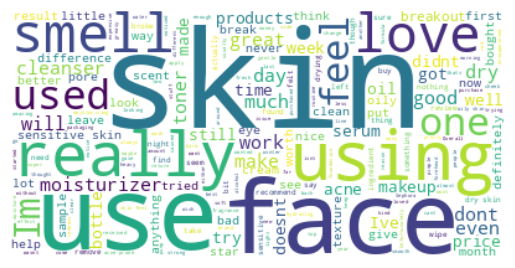

In [24]:
generate_wordcloud(negative)

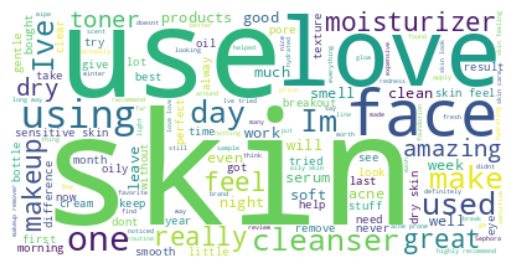

In [25]:
generate_wordcloud(positive)

In [26]:
df['Category'].value_counts()

Category
Cleanser       4117
Moisturizer    2560
Treatment      1948
Face Mask        24
Name: count, dtype: int64

In [27]:
moist_df = df[df.Category=='Moisturizer']
moist_df.head()

Username Skin_Tone Skin_Type Eye_Color Hair_Color  Rating_Stars  \
432        JazminLR      Deep       Dry     Brown      Black             5   
433          E12355   No data   No data   No data    No data             2   
434         lenstar       Tan    Normal     Brown      Black             2   
435  ramblinfirefox     Olive       Dry     Brown   Brunette             4   
436         KateraS     Olive    Normal     Hazel   Brunette             5   

                                                Review        Product  \
432  I love it is a must have product I use for my ...  Beauty Elixir   
433  My skin feels great but I cant bare the strong...  Beauty Elixir   
434  Really wanted to like this product but I was r...  Beauty Elixir   
435  I use this as a setting spray love the scent B...  Beauty Elixir   
436  Fresh Fresh Im a bit of a collector of face sp...  Beauty Elixir   

        Brand  Price  ...  Oily Sensitive     Category  \
432  CAUDALIE     18  ...     1         1  Moisturizer   
433  CAUDALIE     18  ...     1         1  Moisturizer   
434  CAUDALIE     18  ...     1         1  Moisturizer   
435  CAUDALIE     18  ...     1         1  Moisturizer   
436  CAUDALIE     18  ...     1         1  Moisturizer   

                                           Product_Url  User_id  Product_id  \
432  https://www.sephora.com/product/beauty-elixir-...     1309          32   
433  https://www.sephora.com/product/beauty-elixir-...      866          32   
434  https://www.sephora.com/product/beauty-elixir-...     5189          32   
435  https://www.sephora.com/product/beauty-elixir-...     6092          32   
436  https://www.sephora.com/product/beauty-elixir-...     1546          32   

                                   Ingredients_Cleaned  \
432  ['alcohol', 'citrus', 'aurantium', 'amara', 'b...   
433  ['alcohol', 'citrus', 'aurantium', 'amara', 'b...   
434  ['alcohol', 'citrus', 'aurantium', 'amara', 'b...   
435  ['alcohol', 'citrus', 'aurantium', 'amara', 'b...   
436  ['alcohol', 'citrus', 'aurantium', 'amara', 'b...   

                                        Review_Cleaned Good_Stuff  \
432  ['love', 'must', 'use', 'skin', 'care', 'also'...          1   
433  ['skin', 'feel', 'great', 'bare', 'strong', 's...          0   
434  ['really', 'wanted', 'like', 'wa', 'really', '...          0   
435  ['use', 'setting', 'spray', 'love', 'scent', '...          0   
436  ['fresh', 'fresh', 'bit', 'collector', 'face',...          1   

                                             Ing_Tfidf  
432  alcohol, citrus, aurantium, amara, bitter, ora...  
433  alcohol, citrus, aurantium, amara, bitter, ora...  
434  alcohol, citrus, aurantium, amara, bitter, ora...  
435  alcohol, citrus, aurantium, amara, bitter, ora...  
436  alcohol, citrus, aurantium, amara, bitter, ora...  

[5 rows x 25 columns]

In [28]:
cleanse_df = df[df.Category=='Cleanser']
cleanse_df.head()

Username Skin_Tone    Skin_Type Eye_Color Hair_Color  Rating_Stars  \
0      allyp3    Medium  Combination     Brown   Brunette             5   
1      PatTea    Medium  Combination     Brown        Red             1   
2    Sabi1991   No data      No data   No data    No data             5   
3  happyface2      Fair          Dry      Blue     Blonde             5   
4    kimkix34      Fair       Normal     Green     Blonde             5   

                                              Review  \
0  This is hands down the best cleanser Ive ever ...   
1  Unfortunately this doesnt work for everyone I ...   
2  My favorite cleanser i love the packaging on t...   
3  I love all things Youth To The People This cle...   
4  I had a trial size of this and was obsessed My...   

                          Product                Brand  Price  ...  Oily  \
0  Superfood Antioxidant Cleanser  YOUTH TO THE PEOPLE     36  ...     0   
1  Superfood Antioxidant Cleanser  YOUTH TO THE PEOPLE     36  ...     0   
2  Superfood Antioxidant Cleanser  YOUTH TO THE PEOPLE     36  ...     0   
3  Superfood Antioxidant Cleanser  YOUTH TO THE PEOPLE     36  ...     0   
4  Superfood Antioxidant Cleanser  YOUTH TO THE PEOPLE     36  ...     0   

  Sensitive  Category                                        Product_Url  \
0         0  Cleanser  https://www.sephora.com/product/kale-spinach-g...   
1         0  Cleanser  https://www.sephora.com/product/kale-spinach-g...   
2         0  Cleanser  https://www.sephora.com/product/kale-spinach-g...   
3         0  Cleanser  https://www.sephora.com/product/kale-spinach-g...   
4         0  Cleanser  https://www.sephora.com/product/kale-spinach-g...   

   User_id  Product_id                                Ingredients_Cleaned  \
0     3420         157  ['sodium', 'cocoyl', 'glutamate', 'cocamidopro...   
1     2483         157  ['sodium', 'cocoyl', 'glutamate', 'cocamidopro...   
2     2715         157  ['sodium', 'cocoyl', 'glutamate', 'cocamidopro...   
3     4497         157  ['sodium', 'cocoyl', 'glutamate', 'cocamidopro...   
4     5017         157  ['sodium', 'cocoyl', 'glutamate', 'cocamidopro...   

                                      Review_Cleaned Good_Stuff  \
0  ['hand', 'best', 'cleanser', 'ever', 'used', '...          1   
1  ['unfortunately', 'work', 'everyone', 'used', ...          0   
2  ['favorite', 'cleanser', 'love', 'packaging', ...          1   
3  ['love', 'thing', 'youth', 'people', 'cleanser...          1   
4  ['trial', 'size', 'wa', 'obsessed', 'skin', 'f...          1   

                                           Ing_Tfidf  
0  sodium, cocoyl, glutamate, cocamidopropyl, bet...  
1  sodium, cocoyl, glutamate, cocamidopropyl, bet...  
2  sodium, cocoyl, glutamate, cocamidopropyl, bet...  
3  sodium, cocoyl, glutamate, cocamidopropyl, bet...  
4  sodium, cocoyl, glutamate, cocamidopropyl, bet...  

[5 rows x 25 columns]

In [29]:
mask_df = df[df.Category=='Face Mask']
mask_df.head()

Username Skin_Tone    Skin_Type Eye_Color Hair_Color  Rating_Stars  \
3072   summerstory    Medium  Combination     Brown      Black             1   
3073        Nuelle      Fair  Combination     Hazel   Brunette             4   
3074  MissQueenie1     Olive         Oily     Brown      Black             4   
3075     VivyKowal    Medium  Combination     Green     Blonde             5   
3076        NewAge       Tan  Combination     Brown   Brunette             3   

                                                 Review  \
3072  Its make my skin so dry I had to return it Its...   
3073  This cream doesnt feel heavy on the skin its r...   
3074  I have been using this product for a little bi...   
3075  I love this product I have combo skin and its ...   
3076  Feels nice on the skin and relaxing Love that ...   

                        Product    Brand  Price  ...  Oily Sensitive  \
3072  Time Freeze Sleeping Mask  LANEIGE     39  ...     1         1   
3073  Time Freeze Sleeping Mask  LANEIGE     39  ...     1         1   
3074  Time Freeze Sleeping Mask  LANEIGE     39  ...     1         1   
3075  Time Freeze Sleeping Mask  LANEIGE     39  ...     1         1   
3076  Time Freeze Sleeping Mask  LANEIGE     39  ...     1         1   

       Category                                        Product_Url  User_id  \
3072  Face Mask  https://www.sephora.com/product/time-freeze-sl...     6518   
3073  Face Mask  https://www.sephora.com/product/time-freeze-sl...     2425   
3074  Face Mask  https://www.sephora.com/product/time-freeze-sl...     2189   
3075  Face Mask  https://www.sephora.com/product/time-freeze-sl...     3234   
3076  Face Mask  https://www.sephora.com/product/time-freeze-sl...     2354   

      Product_id                                Ingredients_Cleaned  \
3072         274  ['propanediol', 'avena', 'sativa', 'oat', 'ker...   
3073         274  ['propanediol', 'avena', 'sativa', 'oat', 'ker...   
3074         274  ['propanediol', 'avena', 'sativa', 'oat', 'ker...   
3075         274  ['propanediol', 'avena', 'sativa', 'oat', 'ker...   
3076         274  ['propanediol', 'avena', 'sativa', 'oat', 'ker...   

                                         Review_Cleaned Good_Stuff  \
3072  ['make', 'skin', 'dry', 'return', 'freeze', 't...          0   
3073  ['cream', 'feel', 'heavy', 'skin', 'recommende...          0   
3074  ['using', 'little', 'bit', 'month', 'love', 'k...          0   
3075  ['love', 'combo', 'skin', 'perfectly', 'absorb...          1   
3076  ['feel', 'nice', 'skin', 'relaxing', 'love', '...          0   

                                              Ing_Tfidf  
3072  propanediol, avena, sativa, oat, kernel, extra...  
3073  propanediol, avena, sativa, oat, kernel, extra...  
3074  propanediol, avena, sativa, oat, kernel, extra...  
3075  propanediol, avena, sativa, oat, kernel, extra...  
3076  propanediol, avena, sativa, oat, kernel, extra...  

[5 rows x 25 columns]

In [30]:
treat_df = df[df.Category=='Treatment']
treat_df['Ingredients']

6500    Water, Isodecyl Neopentanoate, Polymethylsilse...
6501    Water, Isodecyl Neopentanoate, Polymethylsilse...
6502    Water, Isodecyl Neopentanoate, Polymethylsilse...
6503    Water, Isodecyl Neopentanoate, Polymethylsilse...
6504    Water, Isodecyl Neopentanoate, Polymethylsilse...
                              ...                        
8674    The Microdelivery Peel Step I:\r\r\nPeg-6, Sod...
8675    The Microdelivery Peel Step I:\r\r\nPeg-6, Sod...
8676    The Microdelivery Peel Step I:\r\r\nPeg-6, Sod...
8677    The Microdelivery Peel Step I:\r\r\nPeg-6, Sod...
8678    The Microdelivery Peel Step I:\r\r\nPeg-6, Sod...
Name: Ingredients, Length: 1948, dtype: object

Now making wordclouds for these dataframes's ingredients and for that first form strings and then generate wordclouds

In [31]:
moist = " ".join(intgredient for intgredient in moist_df.Ingredients)
'''Assuming moist_df is a DataFrame and Ingredients is one of its columns, 
this code is using a list comprehension to iterate over the values in the Ingredients column of the DataFrame and join
them into a single string using a space as the separator. 
This can be useful for creating a single text string from a column of text values, such as when preparing text data 
for further analysis or processing.'''
moist

"Water, Alcohol*, Citrus Aurantium Amara (Bitter Orange) Flower Water*, Parfum (Fragrance)*, Rosmarinus Officinalis (Rosemary) Leaf Oil*, Potassium Alum, Glycerin*, Mentha Piperita (Peppermint) Oil*, Styrax Tonkinensis Resin Extract*, Commiphora Myrrha Resin Extract*, Melissa Officinalis (Balm Mint) Leaf Oil*, Rosa Damascena Flower Oil*, Vitis Vinifera (Grape) Fruit Extract*, Tocopherol*, Citral*, Limonene*, Linalool*, Citronellol*, Geraniol*, Farnesol*, Benzyl Benzoate*, Eugenol*. *Plant origin. Water, Alcohol*, Citrus Aurantium Amara (Bitter Orange) Flower Water*, Parfum (Fragrance)*, Rosmarinus Officinalis (Rosemary) Leaf Oil*, Potassium Alum, Glycerin*, Mentha Piperita (Peppermint) Oil*, Styrax Tonkinensis Resin Extract*, Commiphora Myrrha Resin Extract*, Melissa Officinalis (Balm Mint) Leaf Oil*, Rosa Damascena Flower Oil*, Vitis Vinifera (Grape) Fruit Extract*, Tocopherol*, Citral*, Limonene*, Linalool*, Citronellol*, Geraniol*, Farnesol*, Benzyl Benzoate*, Eugenol*. *Plant origi

In [32]:
cleanse = " ".join(ingredient for ingredient in cleanse_df.Ingredients)
cleanse

"Water, Sodium Cocoyl Glutamate, Cocamidopropyl Betaine, Panthenol (Vitamin B5),Tocopheryl Acetate (Vitamin E), Ascorbic Acid (Vitamin C), Butylene Glycol, Brassica Oleracea(Kale) Leaf Extract, Spinacia Oleracea (Spinach) Leaf Extract, Camellia Sinensis (Green Tea)Leaf Extract, Chamomilla Recutita (Matricaria) Flower Extract, Medicago Sativa (Alfalfa) Extract,Aloe Barbadensis (Aloe Vera) Leaf Extract, Natural Fragrance, Lecithin, HydroxypropylMethylcellulose, Phenoxyethanol, Potassium Sorbate, Sodium Benzoate, Chlorophyll. Water, Sodium Cocoyl Glutamate, Cocamidopropyl Betaine, Panthenol (Vitamin B5),Tocopheryl Acetate (Vitamin E), Ascorbic Acid (Vitamin C), Butylene Glycol, Brassica Oleracea(Kale) Leaf Extract, Spinacia Oleracea (Spinach) Leaf Extract, Camellia Sinensis (Green Tea)Leaf Extract, Chamomilla Recutita (Matricaria) Flower Extract, Medicago Sativa (Alfalfa) Extract,Aloe Barbadensis (Aloe Vera) Leaf Extract, Natural Fragrance, Lecithin, HydroxypropylMethylcellulose, Phenoxye

In [33]:
mask = " ".join(int for int in mask_df.Ingredients)
mask

'Water, Propanediol, Avena Sativa (Oat) Kernel Extract, Glycerin, Cyclopentasiloxane, Dimethicone, Squalane, Cyclohexasiloxane, Ceratonia Siliqua (Carob) Fruit Extract, Hibiscus Abelmoschus Seed Extract, Tillandsia Usneoides Extract, Adenosine, Hydrogenated Lecithin, C12-16 Alcohols, Glyceryl Caprylate, Dextrin, Dimethicone / Vinyl Dimethicone Crosspolymer, Dipalmitoyl Hydroxyproline, Butylene Glycol, Cetearyl Glucoside, Cetearyl Alcohol, Ethylhexylglycerin, Xanthan Gum, Theobroma Cacao (Cocoa) Extract, Palmitic Acid, Polysorbate 20, PVP, PEG-240 / HDI Copolymer Bis-Decyltetradeceth-20 Ether, Hydroxyethyl Acrylate / Sodium Acryloyldimethyl Taurate Copolymer, Disodium EDTA, Phenoxyethanol, Fragrance. Water, Propanediol, Avena Sativa (Oat) Kernel Extract, Glycerin, Cyclopentasiloxane, Dimethicone, Squalane, Cyclohexasiloxane, Ceratonia Siliqua (Carob) Fruit Extract, Hibiscus Abelmoschus Seed Extract, Tillandsia Usneoides Extract, Adenosine, Hydrogenated Lecithin, C12-16 Alcohols, Glycery

In [34]:
treat = " ".join(ing for ing in treat_df.Ingredients)
treat

"Water, Isodecyl Neopentanoate, Polymethylsilsesquioxane, Glycerin, Pentylene Glycol, Neopentyl Glycol Diethylhexanoate, Cetyl Ethylhexanoate, Stearic Acid, Cetearyl Olivate, Dimethicone/Bis-Isobutyl PPG-20 Crosspolymer, Sorbitan Olivate, Butylene Glycol, Honey, Urea, Yeast Amino Acids, Trehalose, Inositol, Taurine, Betaine, Caprylic/Capric Triglyceride, Alaria Esculenta Extract, Palmitoyl Tripeptide-5, Codium Tomentosum Extract, Hydrogenated Olive Oil, Olive Fruit Oil, Olive Oil Unsaponifiables, Sodium Hyaluronate, Collagen Amino Acids, Watermelon Fruit Extract, Apple Fruit Extract, Lentil Fruit Extract, Tocopheryl Acetate, Sodium PCA, Sodium Lactate, Zinc Gluconate, Ascorbic Acid, Chitosan, Propyl Gallate, Polysorbate 20, Acrylates/C10-30 Alkyl Acrylate Crosspolymer, Aminomethyl Propanol, Trisodium Ethylenediamine Disuccinate, Disodium EDTA, Phenoxyethanol, Caprylyl Glycol, Chlorphenesin, Linalool, Anthemis Nobilis Flower Extract, Anthemis Nobilis Flower Oil, Lavender Oil. Water, Iso

**Now generating wordclouds from these strings of dataframes that contain ingredients**

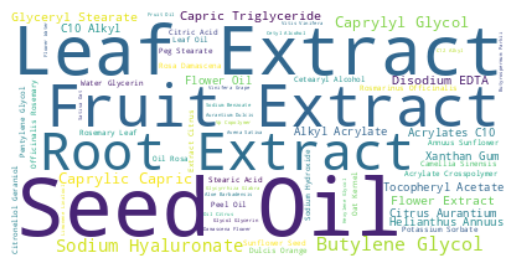

In [35]:
generate_wordcloud(moist)

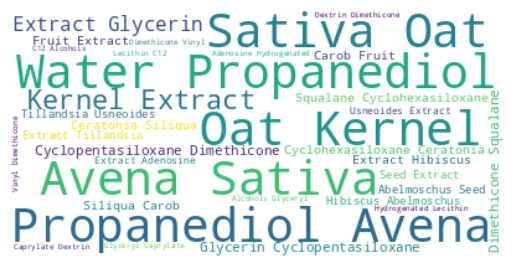

In [36]:
generate_wordcloud(mask)

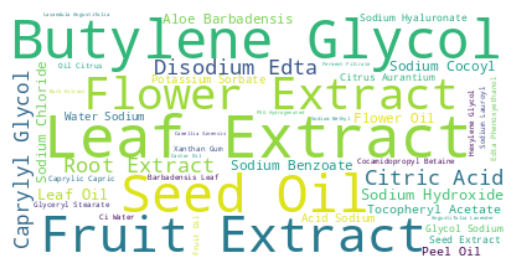

In [37]:
generate_wordcloud(cleanse)

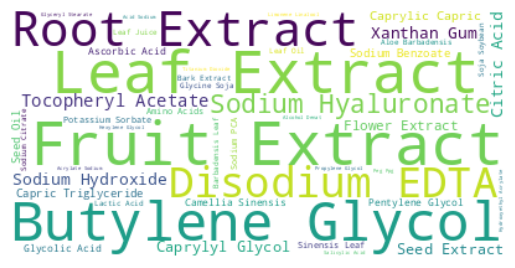

In [38]:
generate_wordcloud(treat)

### Now using NB Classifier

In [39]:
X = df.Ingredients
y = df.Category
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.25,random_state=42)
categories = ['Moisturizer','Cleanser','Face Mask','Treatment']


In [40]:
nb_clalssifier = Pipeline([('vect',CountVectorizer()),
                           ('tfid',TfidfTransformer()),
                           ('clf',MultinomialNB())])
#Transformer will do normalization


In [41]:
nb_clalssifier.fit(X_train,y_train)        #Training our model

Pipeline(steps=[('vect', CountVectorizer()), ('tfid', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [42]:
y_pred=nb_clalssifier.predict(X_test)

### Accuracy

In [43]:
print(f"Accuracy : {accuracy_score(y_pred,y_test)*100} ")

Accuracy : 96.53259361997226 


In [44]:
print(classification_report(y_test,y_pred,target_names=categories))

              precision    recall  f1-score   support

 Moisturizer       0.96      0.99      0.98      1031
    Cleanser       0.00      0.00      0.00         9
   Face Mask       0.99      0.96      0.98       649
   Treatment       0.94      0.92      0.93       474

    accuracy                           0.97      2163
   macro avg       0.72      0.72      0.72      2163
weighted avg       0.96      0.97      0.96      2163



### Now using logistic regression

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression

log_reg = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(n_jobs=1, C=1e5))
])


In [46]:
log_reg.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=100000.0, n_jobs=1))])

In [47]:
y_pred = log_reg.predict(X_test)

In [48]:
print(f"Accuracy : {accuracy_score(y_pred,y_test)*100}")

Accuracy : 98.38187702265373


In [49]:
print(classification_report(y_test,y_pred,target_names=categories))

              precision    recall  f1-score   support

 Moisturizer       0.99      0.98      0.98      1031
    Cleanser       1.00      1.00      1.00         9
   Face Mask       0.97      1.00      0.98       649
   Treatment       0.98      0.99      0.98       474

    accuracy                           0.98      2163
   macro avg       0.99      0.99      0.99      2163
weighted avg       0.98      0.98      0.98      2163



### Now using SGD Classifier

In [50]:
from sklearn.linear_model import SGDClassifier

sgd_classifier = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5))
])

In [51]:
sgd_classifier.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42))])

In [52]:
y_pred = sgd_classifier.predict(X_test)

In [53]:
print(f"Accuracy : {accuracy_score(y_pred,y_test)*100}")

Accuracy : 97.54969949144706


In [54]:
print(classification_report(y_test,y_pred,target_names=categories))

              precision    recall  f1-score   support

 Moisturizer       0.99      0.97      0.98      1031
    Cleanser       1.00      1.00      1.00         9
   Face Mask       0.96      1.00      0.98       649
   Treatment       0.97      0.96      0.96       474

    accuracy                           0.98      2163
   macro avg       0.98      0.98      0.98      2163
weighted avg       0.98      0.98      0.98      2163



**Thus logistic regression is the best classifier**

### Building classifier for quality and effectivness of ingredients 

In [55]:
X_1 = df.Ingredients
y_1 = df.Good_Stuff

In [56]:
X_1_train , X_1_test , y_1_train, y_1_test = train_test_split(X_1,y_1, test_size=0.25, random_state=42)

In [57]:
cat=['1','0']

### Using Naive-Bayes Classifier 

In [58]:
nb_classifier_1 = Pipeline([('vect',CountVectorizer()),
                           ('tfid',TfidfTransformer()),
                           ('clf',MultinomialNB())])
nb_classifier_1.fit(X_1_train,y_1_train)
y_1_pred = nb_classifier_1.predict(X_1_test)
print(f"Accuracy : {accuracy_score(y_1_pred,y_1_test)*100}")

Accuracy : 59.731853906611185


In [59]:
print(classification_report(y_1_test,y_1_pred))

              precision    recall  f1-score   support

           0       0.48      0.25      0.33       856
           1       0.63      0.82      0.71      1307

    accuracy                           0.60      2163
   macro avg       0.56      0.54      0.52      2163
weighted avg       0.57      0.60      0.56      2163



### Using Logistic Regression Classifier

In [60]:
log_reg_1 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(n_jobs=1, C=1e5))
])
log_reg_1.fit(X_1_train,y_1_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=100000.0, n_jobs=1))])

In [61]:
y_1_pred = log_reg_1.predict(X_1_test)

In [62]:
print(f"Accuracy : {accuracy_score(y_1_pred,y_1_test)*100}")

Accuracy : 60.10171058714748


In [63]:
print(classification_report(y_1_test,y_1_pred))

              precision    recall  f1-score   support

           0       0.49      0.27      0.35       856
           1       0.63      0.82      0.71      1307

    accuracy                           0.60      2163
   macro avg       0.56      0.54      0.53      2163
weighted avg       0.58      0.60      0.57      2163



### Using SGD Classifier

In [64]:
sgd_classifier_1 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5))
])
sgd_classifier_1.fit(X_1_train,y_1_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42))])

In [65]:
y_1_pred = sgd_classifier_1.predict(X_1_test)

In [66]:
print(f"Accuracy : {accuracy_score(y_1_pred,y_1_test)*100}")

Accuracy : 61.165048543689316


In [67]:
print(classification_report(y_1_test,y_1_pred))

              precision    recall  f1-score   support

           0       0.61      0.05      0.09       856
           1       0.61      0.98      0.75      1307

    accuracy                           0.61      2163
   macro avg       0.61      0.51      0.42      2163
weighted avg       0.61      0.61      0.49      2163



**Here also SDG gives the best accuracy but accuracy is very poor.**

In [68]:
def recommend_products_by_user_features(skintone,eyecolor,skintype,haircolor):
    ddf =  df[(df['Skin_Tone']==skintone) & (df['Eye_Color']==eyecolor) & (df['Skin_Type']==skintype) & (df['Hair_Color']==haircolor) ]
    recommendations = ddf[(ddf['Rating_Stars'].notnull())][['Rating_Stars','Product_Url','Product']]
    recommendations = recommendations.sort_values('Rating_Stars',ascending=False).head()
    print('Based on your features these are the top products for you')
    return recommendations

In [69]:
skintone = str(input("Enter Skin Tone: "))
eyecolor = str(input("Enter Eye Color: "))
skintype = str(input("Enter Skin Type: "))
haircolor = str(input("Enter Hair Color: "))

In [70]:
recommend_products_by_user_features(skintone,eyecolor,skintype,haircolor)

Based on your features these are the top products for you


Empty DataFrame
Columns: [Rating_Stars, Product_Url, Product]
Index: []

In [71]:
# Now using integredients of products
from sklearn.metrics.pairwise import linear_kernel,cosine_similarity

df_cont = df[['Product','Product_id','Ingredients','Product_Url','Ing_Tfidf','Rating']].copy()  # Make a copy to avoid warnings
df_cont = df_cont.drop_duplicates(subset=['Product']).reset_index(drop=True)  # Drop duplicates and reset index

df_cont.head()

Product  Product_id  \
0         Superfood Antioxidant Cleanser         157   
1          Cleansing & Exfoliating Wipes          65   
2            Purity Made Simple Cleanser         210   
3            Beste™ No. 9 Jelly Cleanser          35   
4  The Rice Polish Foaming Enzyme Powder         196   

                                         Ingredients  \
0  Water, Sodium Cocoyl Glutamate, Cocamidopropyl...   
1  Water, Caprylic/Capric Triglyceride, Fragrance...   
2  Water, Sodium Lauroamphoacetate, Sodium Tridec...   
3  Water, Sodium Lauroyl Methyl Isethionate, Glyc...   
4  Microcrystalline Cellulose, Oryza Sativa (Rice...   

                                         Product_Url  \
0  https://www.sephora.com/product/kale-spinach-g...   
1  https://www.sephora.com/product/cleansing-exfo...   
2  https://www.sephora.com/product/purity-made-si...   
3  https://www.sephora.com/product/beste-no-9-jel...   
4  https://www.sephora.com/product/polished-rice-...   

                                           Ing_Tfidf  Rating  
0  sodium, cocoyl, glutamate, cocamidopropyl, bet...     4.4  
1  caprylic, capric, triglyceride, fragrance, phe...     4.5  
2  sodium, lauroamphoacetate, sodium, trideceth, ...     4.5  
3  sodium, lauroyl, methyl, isethionate, glycerin...     4.1  
4  microcrystalline, cellulose, oryza, sativa, ri...     4.4

In [72]:
df_cont.drop_duplicates(inplace=True)

In [73]:
# Replace lines 293-296 with:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df=0.0, stop_words='english')

tfidf_matrix = tf.fit_transform(df_cont['Ingredients'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

print(f"Shape of cosine similarity matrix: {cosine_sim.shape}")
print(f"Number of products in df_cont: {len(df_cont)}")

Shape of cosine similarity matrix: (315, 315)
Number of products in df_cont: 315


In [74]:
df_cont.head()

Product  Product_id  \
0         Superfood Antioxidant Cleanser         157   
1          Cleansing & Exfoliating Wipes          65   
2            Purity Made Simple Cleanser         210   
3            Beste™ No. 9 Jelly Cleanser          35   
4  The Rice Polish Foaming Enzyme Powder         196   

                                         Ingredients  \
0  Water, Sodium Cocoyl Glutamate, Cocamidopropyl...   
1  Water, Caprylic/Capric Triglyceride, Fragrance...   
2  Water, Sodium Lauroamphoacetate, Sodium Tridec...   
3  Water, Sodium Lauroyl Methyl Isethionate, Glyc...   
4  Microcrystalline Cellulose, Oryza Sativa (Rice...   

                                         Product_Url  \
0  https://www.sephora.com/product/kale-spinach-g...   
1  https://www.sephora.com/product/cleansing-exfo...   
2  https://www.sephora.com/product/purity-made-si...   
3  https://www.sephora.com/product/beste-no-9-jel...   
4  https://www.sephora.com/product/polished-rice-...   

                                           Ing_Tfidf  Rating  
0  sodium, cocoyl, glutamate, cocamidopropyl, bet...     4.4  
1  caprylic, capric, triglyceride, fragrance, phe...     4.5  
2  sodium, lauroamphoacetate, sodium, trideceth, ...     4.5  
3  sodium, lauroyl, methyl, isethionate, glycerin...     4.1  
4  microcrystalline, cellulose, oryza, sativa, ri...     4.4

In [75]:
# As our distribution is not in order
df_cont.reset_index(drop=True)

Product  Product_id  \
0                       Superfood Antioxidant Cleanser         157   
1                        Cleansing & Exfoliating Wipes          65   
2                          Purity Made Simple Cleanser         210   
3                          Beste™ No. 9 Jelly Cleanser          35   
4                The Rice Polish Foaming Enzyme Powder         196   
..                                                 ...         ...   
310      Midnight Secret Late Night Recovery Treatment         173   
311                      Post-Acne Spot Lightening Gel         198   
312    Hydro-Plumping Re-Texturizing Serum Concentrate         150   
313                 The Microdelivery Resurfacing Peel         266   
314  Ferulic + Retinol Wrinkle Recovery Overnight S...         124   

                                           Ingredients  \
0    Water, Sodium Cocoyl Glutamate, Cocamidopropyl...   
1    Water, Caprylic/Capric Triglyceride, Fragrance...   
2    Water, Sodium Lauroamphoacetate, Sodium Tridec...   
3    Water, Sodium Lauroyl Methyl Isethionate, Glyc...   
4    Microcrystalline Cellulose, Oryza Sativa (Rice...   
..                                                 ...   
310                        Visit the Guerlain boutique   
311  Water, Alcohol Denat., Glycolic Acid, Butylene...   
312  Water, Glycerin, Dimethicone, Propanediol, Dim...   
313  The Microdelivery Peel Step I:\r\r\nPeg-6, Sod...   
314  Water, DiCaprylyl Carbonate, Niacinamide, Cety...   

                                           Product_Url  \
0    https://www.sephora.com/product/kale-spinach-g...   
1    https://www.sephora.com/product/cleansing-exfo...   
2    https://www.sephora.com/product/purity-made-si...   
3    https://www.sephora.com/product/beste-no-9-jel...   
4    https://www.sephora.com/product/polished-rice-...   
..                                                 ...   
310  https://www.sephora.com/product/midnight-secre...   
311  https://www.sephora.com/product/post-acne-spot...   
312  https://www.sephora.com/product/hydro-plumping...   
313  https://www.sephora.com/product/the-microdeliv...   
314  https://www.sephora.com/product/ferulic-retino...   

                                             Ing_Tfidf  Rating  
0    sodium, cocoyl, glutamate, cocamidopropyl, bet...     4.4  
1    caprylic, capric, triglyceride, fragrance, phe...     4.5  
2    sodium, lauroamphoacetate, sodium, trideceth, ...     4.5  
3    sodium, lauroyl, methyl, isethionate, glycerin...     4.1  
4    microcrystalline, cellulose, oryza, sativa, ri...     4.4  
..                                                 ...     ...  
310                          visit, guerlain, boutique     4.2  
311  alcohol, denat, glycolic, acid, butylene, glyc...     3.7  
312  glycerin, dimethicone, propanediol, dimethicon...     4.7  
313  microdelivery, peel, step, peg, sodium, bicarb...     4.7  
314  dicaprylyl, carbonate, niacinamide, cetyl, alc...     4.4  

[315 rows x 6 columns]

In [76]:
# For multiple cols use [[]]
titles = df_cont[['Product','Ingredients','Rating']]  # Fixed column name
titles.head()

Product  \
0         Superfood Antioxidant Cleanser   
1          Cleansing & Exfoliating Wipes   
2            Purity Made Simple Cleanser   
3            Beste™ No. 9 Jelly Cleanser   
4  The Rice Polish Foaming Enzyme Powder   

                                         Ingredients  Rating  
0  Water, Sodium Cocoyl Glutamate, Cocamidopropyl...     4.4  
1  Water, Caprylic/Capric Triglyceride, Fragrance...     4.5  
2  Water, Sodium Lauroamphoacetate, Sodium Tridec...     4.5  
3  Water, Sodium Lauroyl Methyl Isethionate, Glyc...     4.1  
4  Microcrystalline Cellulose, Oryza Sativa (Rice...     4.4

In [77]:
indices = pd.Series(df_cont.index, index=df_cont['Product'])  # Recreate indices after deduplication
indices

Product
Superfood Antioxidant Cleanser                          0
Cleansing & Exfoliating Wipes                           1
Purity Made Simple Cleanser                             2
Beste™ No. 9 Jelly Cleanser                             3
The Rice Polish Foaming Enzyme Powder                   4
                                                     ... 
Midnight Secret Late Night Recovery Treatment         310
Post-Acne Spot Lightening Gel                         311
Hydro-Plumping Re-Texturizing Serum Concentrate       312
The Microdelivery Resurfacing Peel                    313
Ferulic + Retinol Wrinkle Recovery Overnight Serum    314
Length: 315, dtype: int64

In [78]:
indices['Cleansing & Exfoliating Wipes']

np.int64(1)

In [79]:
# Returns recommendation on the basis of similarity
def content_recommendation(product):
    idx=indices[product]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores,key=lambda x : x[1] , reverse=True)
    sim_scores = sim_scores[1:11]      #Returns top 10 recommendations
    product_indices = [i[0] for i in sim_scores]
    return titles.iloc[product_indices]

In [80]:
def evaluate_with_pseudo_ground_truth(product_name, k=10):
    """
    Evaluate recommendations using pseudo ground truth based on similarity scores
    """
    try:
        # Get the product index
        idx = indices[product_name]
        
        # Get similarity scores for this product
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        
        # Create pseudo ground truth: items with similarity score > threshold
        # Let's use the top 5% of similar items as "relevant" for this example
        threshold_idx = max(1, len(sim_scores) // 20)  # Top 5% of items
        relevant_items = [i[0] for i in sim_scores[1:threshold_idx+1]]  # Skip the item itself
        
        # Get recommendations (top k similar items)
        recommendations = content_recommendation(product_name)
        recommended_items = recommendations.index.tolist()[:k]
        
        # Calculate metrics
        prec = precision_at_k(relevant_items, recommended_items, k)
        rec = recall_at_k(relevant_items, recommended_items, k)
        
        # For NDCG, we need relevance scores for the recommended items
        # Create a list of relevance scores for recommended items
        recommended_scores = []
        for item_idx in recommended_items:
            score = cosine_sim[idx][item_idx]
            recommended_scores.append(score)
        
        ndcg = ndcg_at_k(relevant_items, recommended_scores, k)
        
        print(f"Evaluation results for '{product_name}':")
        print(f"Precision@{k}: {prec:.4f}")
        print(f"Recall@{k}: {rec:.4f}")
        print(f"NDCG@{k}: {ndcg:.4f}")
        
        return prec, rec, ndcg
    except Exception as e:
        print(f"Error in evaluation: {e}")
        return None, None, None

# Example usage
evaluate_with_pseudo_ground_truth('The Rice Polish Foaming Enzyme Powder')

Evaluation results for 'The Rice Polish Foaming Enzyme Powder':
Precision@10: 1.0000
Recall@10: 0.6667
NDCG@10: 1.0000


(1.0, 0.6666666666666666, np.float64(1.0))

In [81]:
content_recommendation('The Rice Polish Foaming Enzyme Powder')  
# Returns top 10 recommendations on the basis of product

Product  \
38         The Essence Plumping Skin Softener   
90                   Gold Camellia Beauty Oil   
108                   Purifying Cleansing Gel   
165                 Clear Complexion Cleanser   
43                    Luminous Dewy Skin Mist   
115  EradiKate® Daily Cleanser Acne Treatment   
135       Detoxifying Black Charcoal Cleanser   
307                         Breakout Fighters   
217             United State™ Balancing Tonic   
276              GenOptics Aura Essence Serum   

                                           Ingredients  Rating  
38   Saccharomyces/Camellia Sinensis Leaf/Cladosiph...     4.4  
90   Caprylic/Capric Triglyceride, Ethylhexyl Palmi...     4.6  
108  Water, Hydrogenated Starch Hydrolysate, Diglyc...     4.5  
165  Water, Hydrogenated Starch Hydrolysate, Disodi...     4.4  
43   Water, Glycerin, Squalane (Olive Origin), Cycl...     4.0  
115  Water, Sodium Cocoyl Isethionate, Coco-Glucosi...     4.3  
135  Glycereth-26, Glycerin, Sodium Cocoyl Glutamat...     4.3  
307  Water, Sodium Cocoyl Isethionate, Coco-Glucosi...     4.0  
217  Water; Lavandula Angustifolia (Lavender) Flowe...     4.3  
276  Water, Galactomyces Ferment Filtrate (Pitera),...     4.1